In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  
font = fm.FontProperties(fname=font_path, size=10)
plt.rc('font', family='NanumGothic')  
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
data = pd.read_csv("가공데이터.csv")
train = data.copy()
train.head()

성별        나이   거주지          여행유형    월별    동반자 여행지(시/도) 여행지(시/군/구)  숙박여부  \
0    남자       40대    서울          단순관광    1월  친구/연인      강원도        춘천시     0   
1    여자    15~19세    서울  단순가족/친지/친구방문    2월  친구/연인      경기도        용인시     0   
2    여자       40대    서울  단순가족/친지/친구방문    2월     없음      경기도        용인시     1   
3    남자       40대    서울          단순관광    2월     가족      경기도        안산시     0   
4    여자       60대    서울          단순관광    2월     가족    인천광역시        강화군     0   

              여행비용  
0  10만원 이상 20만원 미만  
1          10만원 미만  
2  10만원 이상 20만원 미만  
3          10만원 미만  
4  10만원 이상 20만원 미만

In [3]:
# 모델 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = pd.get_dummies(train.drop('여행유형', axis=1))  
y = train['여행유형']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [4]:
predictions_rf = rf.predict(X_test)
predictions_rf

array(['가족/친지/친구방문(관광포함)', '단순관광', '단순관광', ..., '단순출장/업무',
       '가족/친지/친구방문(관광포함)', '단순관광'], dtype=object)

In [5]:
from sklearn.model_selection import cross_val_score

accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())

Accuracy:  0.7715827338129496
교차 검증 정확도:  [0.77466598 0.77723535 0.76490236 0.75687484 0.77383706]
평균 정확도:  0.7695031198303831


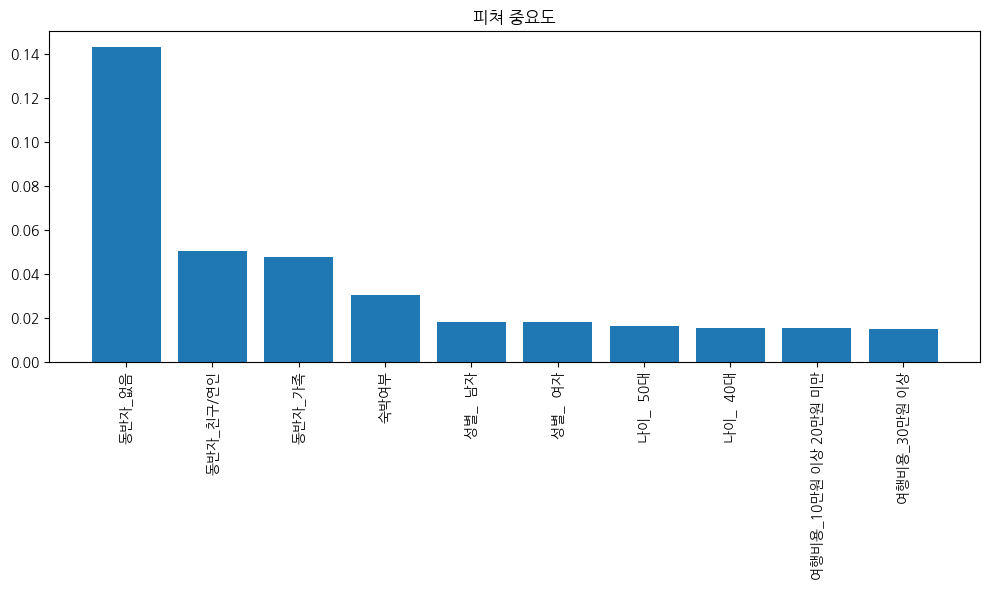

In [6]:
import matplotlib.pyplot as plt


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]  
plt.figure(figsize=(10, 6))
plt.title('피쳐 중요도')
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), X.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig('top_10_feature_importance.png')

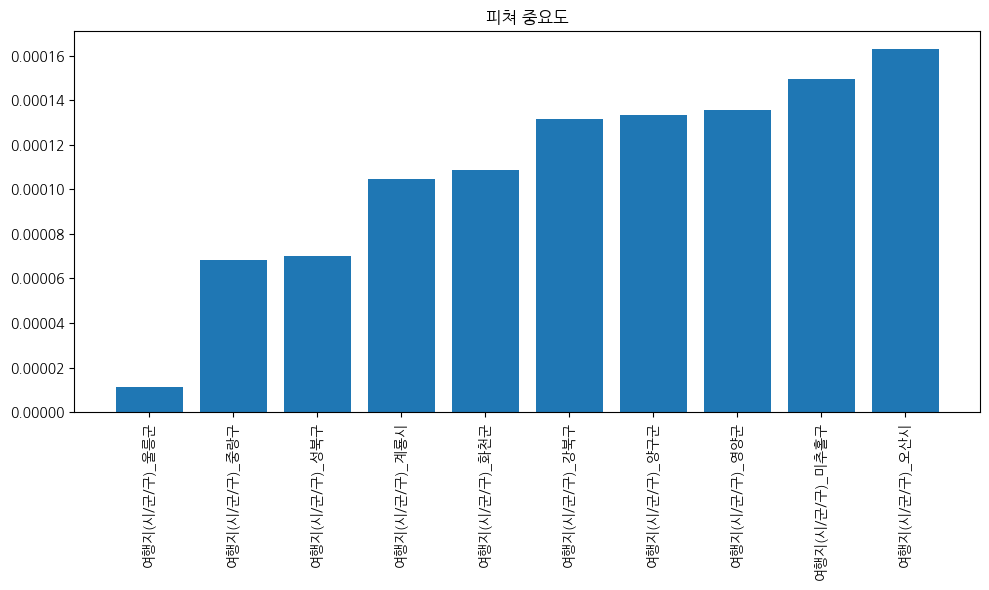

In [7]:
import matplotlib.pyplot as plt

# 특성 중요도 시각화
importances = rf.feature_importances_
indices = np.argsort(importances)[:10]  # 하위 10개의 인덱스 선택
plt.figure(figsize=(10, 6))
plt.title('피쳐 중요도')
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), X.columns[indices], rotation=90)
plt.tight_layout()

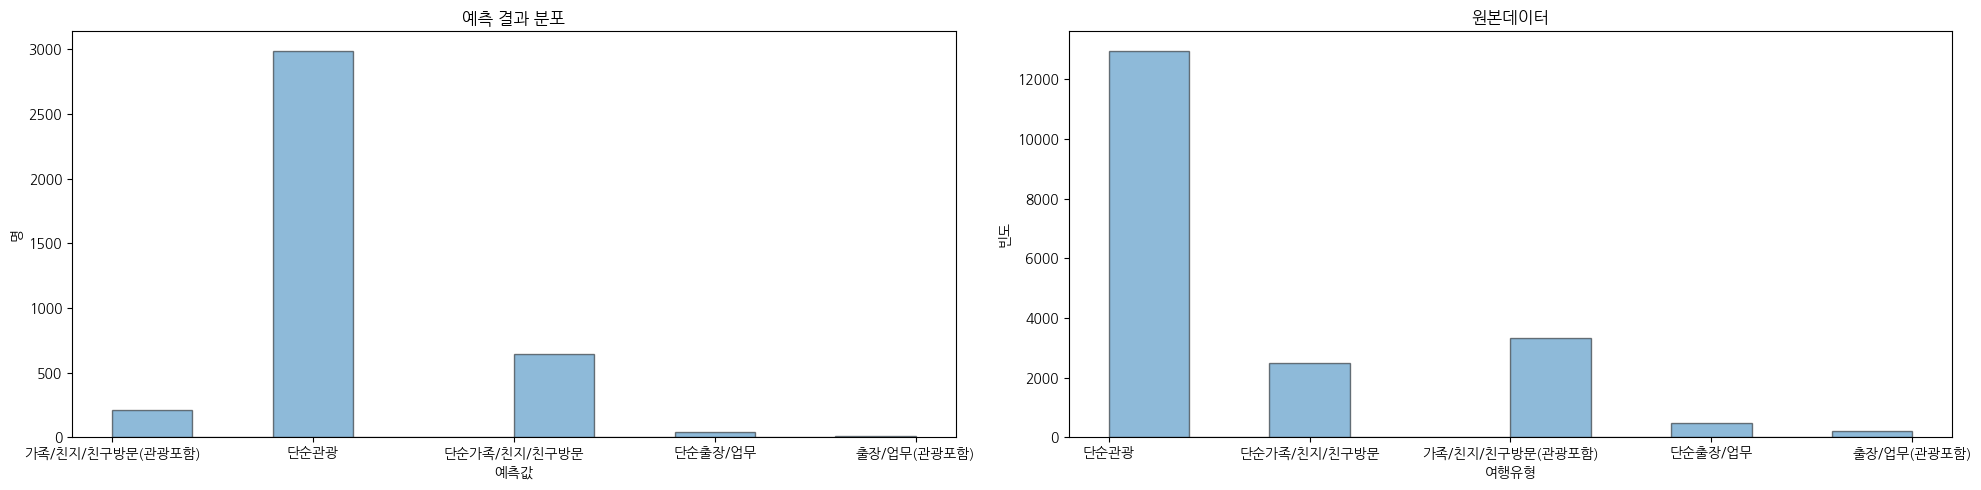

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# 첫 번째 그래프
axs[0].hist(predictions_rf, bins=10, alpha=0.5, edgecolor='black')
axs[0].set_xlabel('예측값')
axs[0].set_ylabel('명')
axs[0].set_title('예측 결과 분포')

# 두 번째 그래프
axs[1].hist(data['여행유형'], bins=10, alpha=0.5, edgecolor='black')
axs[1].set_title('원본데이터')
axs[1].set_xlabel('여행유형')
axs[1].set_ylabel('빈도')

plt.tight_layout()
plt.show()

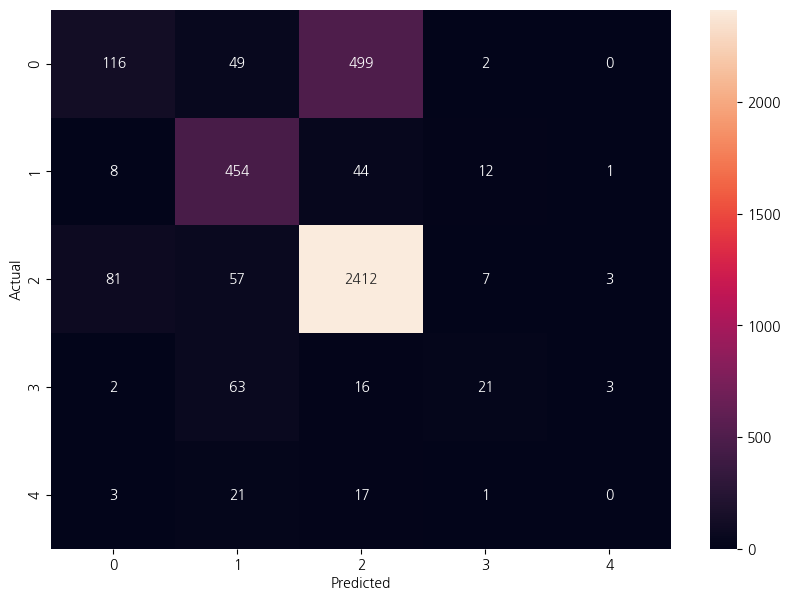

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 오차행렬 해석
- 왼쪽 상단 셀(가운데에서 왼쪽 위에 있는 셀): 진짜 양성(TP). 실제로 해당 클래스이며 모델도 해당 클래스로 예측한 경우
- 오른쪽 상단 셀: 거짓 양성(FP). 실제로는 다른 클래스이지만 모델이 해당 클래스로 잘못 예측한 경우
- 왼쪽 하단 셀: 거짓 음성(FN). 실제로 해당 클래스이지만 모델이 다른 클래스로 잘못 예측한 경우
- 오른쪽 하단 셀(가운데 셀): 진짜 음성(TN). 실제로 다른 클래스이며 모델도 다른 클래스로 예측한 경우

- 가장 많은 데이터 포인트가 올바르게 분류된것(가운데)
- 자주색: 잘못분류된 데이터 포인트 의 수

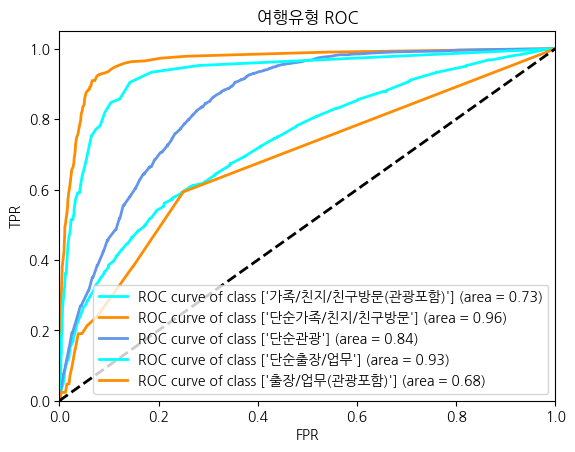

In [10]:
from sklearn import preprocessing
from sklearn.discriminant_analysis import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# 예측 확률을 계산합니다.
y_score = rf.predict_proba(X_test)

# 각 클래스에 대해 ROC 커브를 계산하고 그립니다.
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    original_label = le.inverse_transform([i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(original_label, roc_auc))
    
# 랜덤 추측에 대한 ROC 커브를 그립니다.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('여행유형 ROC')
plt.legend(loc="lower right")
plt.show()

### ROC
- TPR은 실제 양성 중 양성으로 올바르게 분류된 비율을 나타내며, FPR은 실제 음성 중 양성으로 잘못 분류된 비율
- 완벽한 분류기는 (0,1) 지점, 즉 y축 위쪽 끝에 위치
- 대각선 선은 무작위 분류기의 성능
- ROC 커브의 곡선 아래 면적을 AUC(Area Under the Curve)
- ROC 커브가 좌상단에 가까울수록, 그리고 AUC가 1에 가까울수록 모델의 성능이 좋다

### AUC(Area Under the Curve)
- 0과 1 사이의 값을 가지며, 값이 클수록 모델의 성능이 좋다고 판단
- 0.5에 가까울수록 모델이 무작위로 예측하는 수준

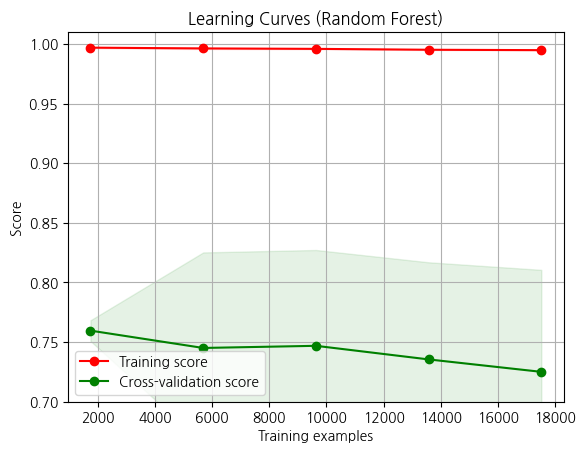

In [105]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 랜덤 포레스트 분류기를 사용한 학습 곡선
title = "Learning Curves (Random Forest)"
cv = 10
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

- 훈련점수와 교차검증 검수의 크기의 차이가 심하면 과대적합의 가능성이 있음.

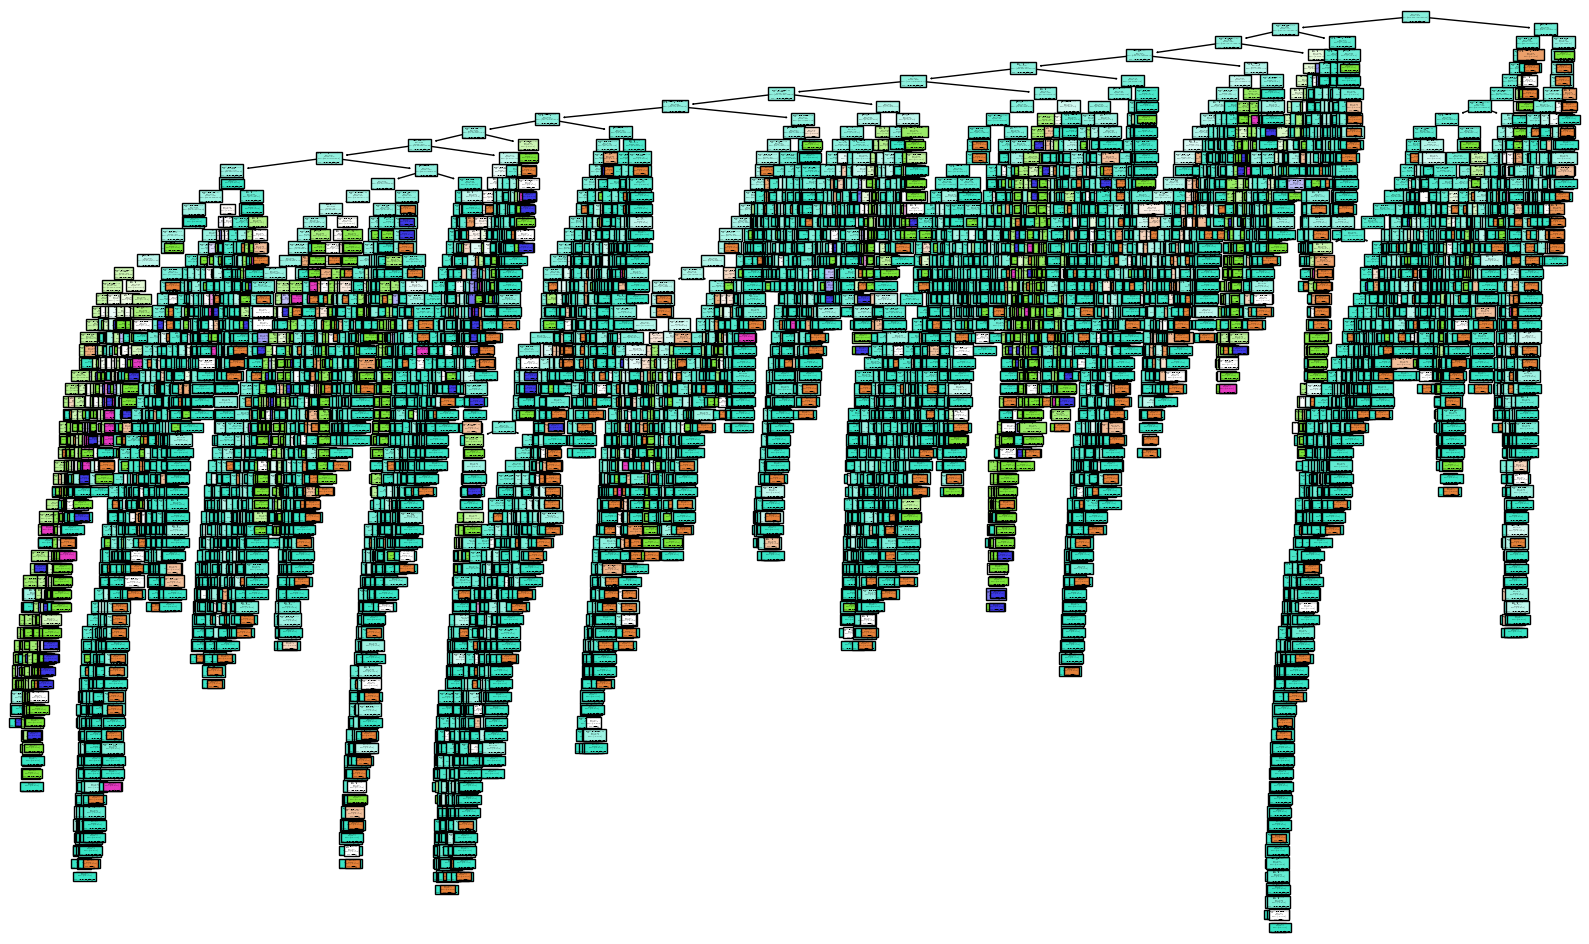

In [49]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


# 첫 번째 트리 시각화
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),  
    filled=True,
    ax=ax
)
plt.show()

In [11]:
train = train.drop('여행지(시/군/구)', axis=1)

In [12]:
# 모델 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = pd.get_dummies(train.drop('여행유형', axis=1))  
y = train['여행유형']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
from sklearn.model_selection import cross_val_score

accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())


Accuracy:  0.7600205549845838
교차 검증 정확도:  [0.77286742 0.7692703  0.75873587 0.74325366 0.76741198]
평균 정확도:  0.7623078450996225


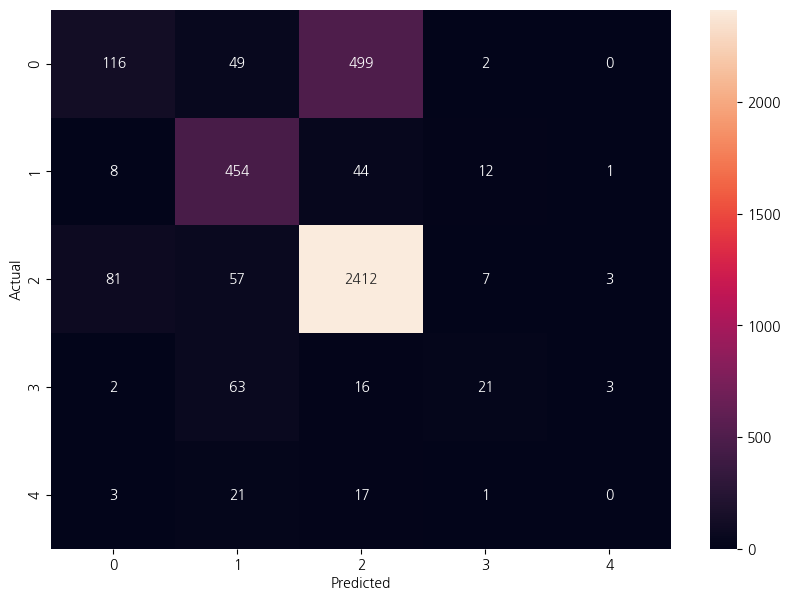

In [14]:
cm = confusion_matrix(y_test, predictions_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

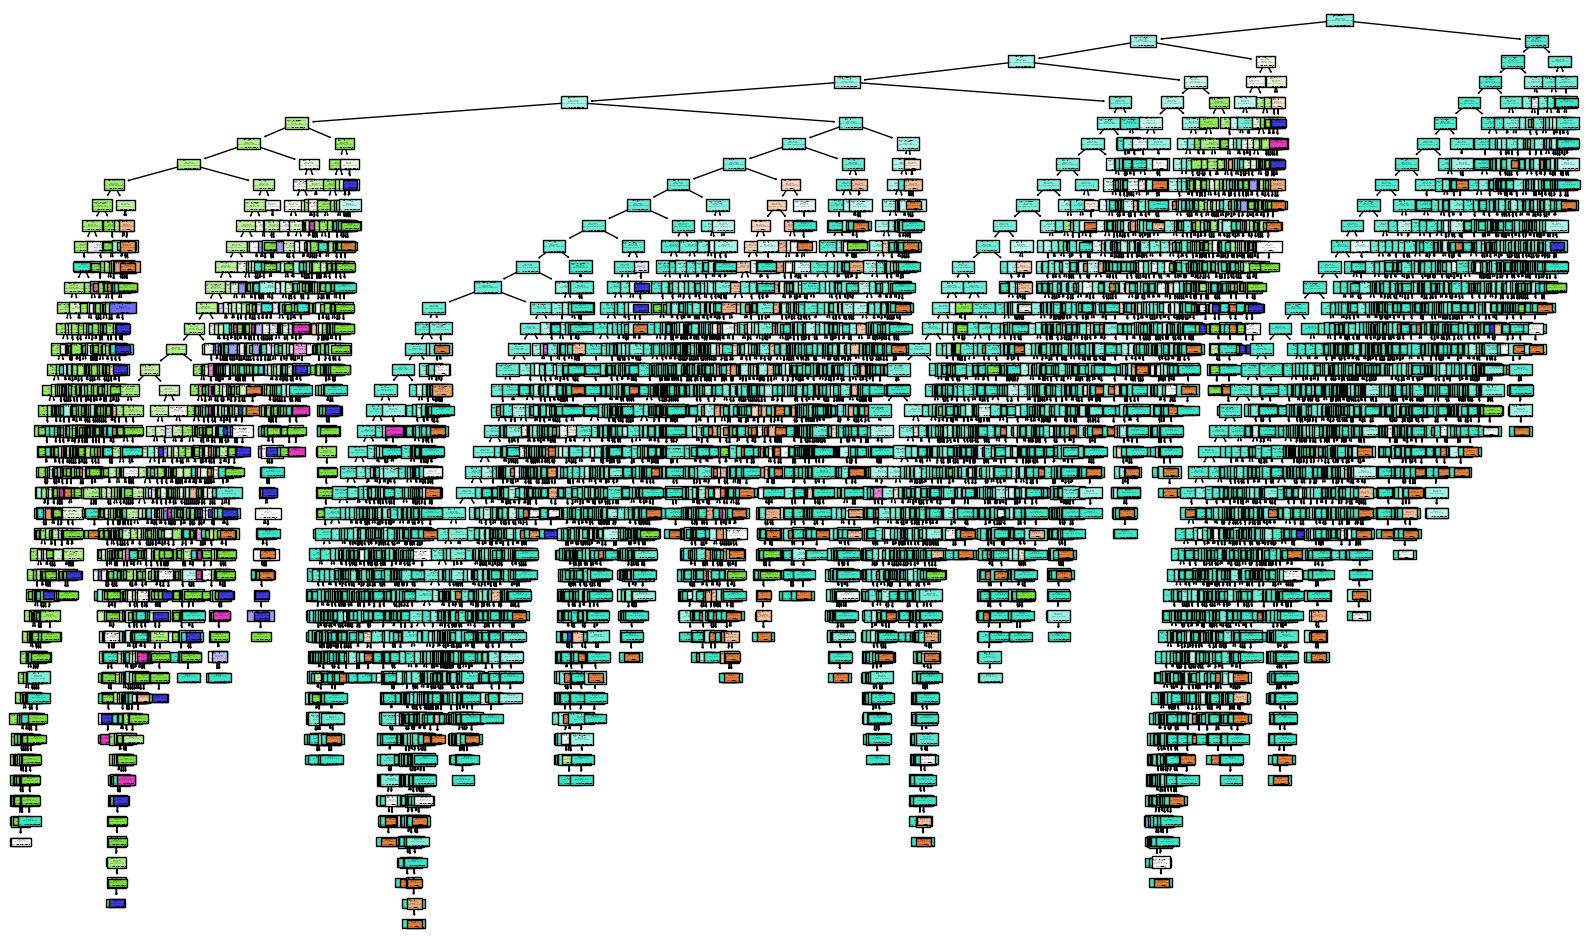

In [53]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


# 첫 번째 트리 시각화
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),  
    filled=True,
    ax=ax
)
plt.show()

In [123]:

rf = RandomForestClassifier(**best_params, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=27,
                       min_samples_leaf=23, min_samples_split=6,
                       n_estimators=166, random_state=42)

In [124]:
accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())


Accuracy:  0.776207605344296
교차 검증 정확도:  [0.7823741  0.78057554 0.76849949 0.77589309 0.78283218]
평균 정확도:  0.7780348779683159


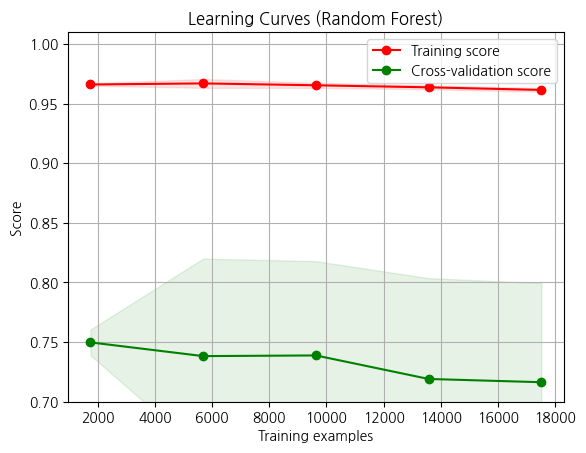

In [125]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 랜덤 포레스트 분류기를 사용한 학습 곡선
title = "Learning Curves (Random Forest)"
cv = 10
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

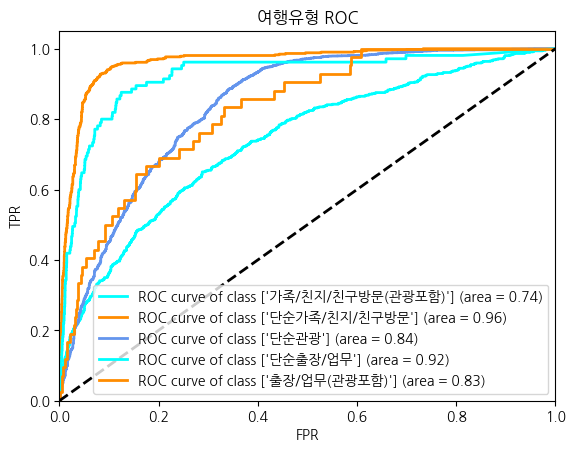

In [127]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# 예측 확률을 계산합니다.
y_score = rf.predict_proba(X_test)

# 각 클래스에 대해 ROC 커브를 계산하고 그립니다.
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    original_label = le.inverse_transform([i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(original_label, roc_auc))
    
# 랜덤 추측에 대한 ROC 커브를 그립니다.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('여행유형 ROC')
plt.legend(loc="lower right")
plt.show()

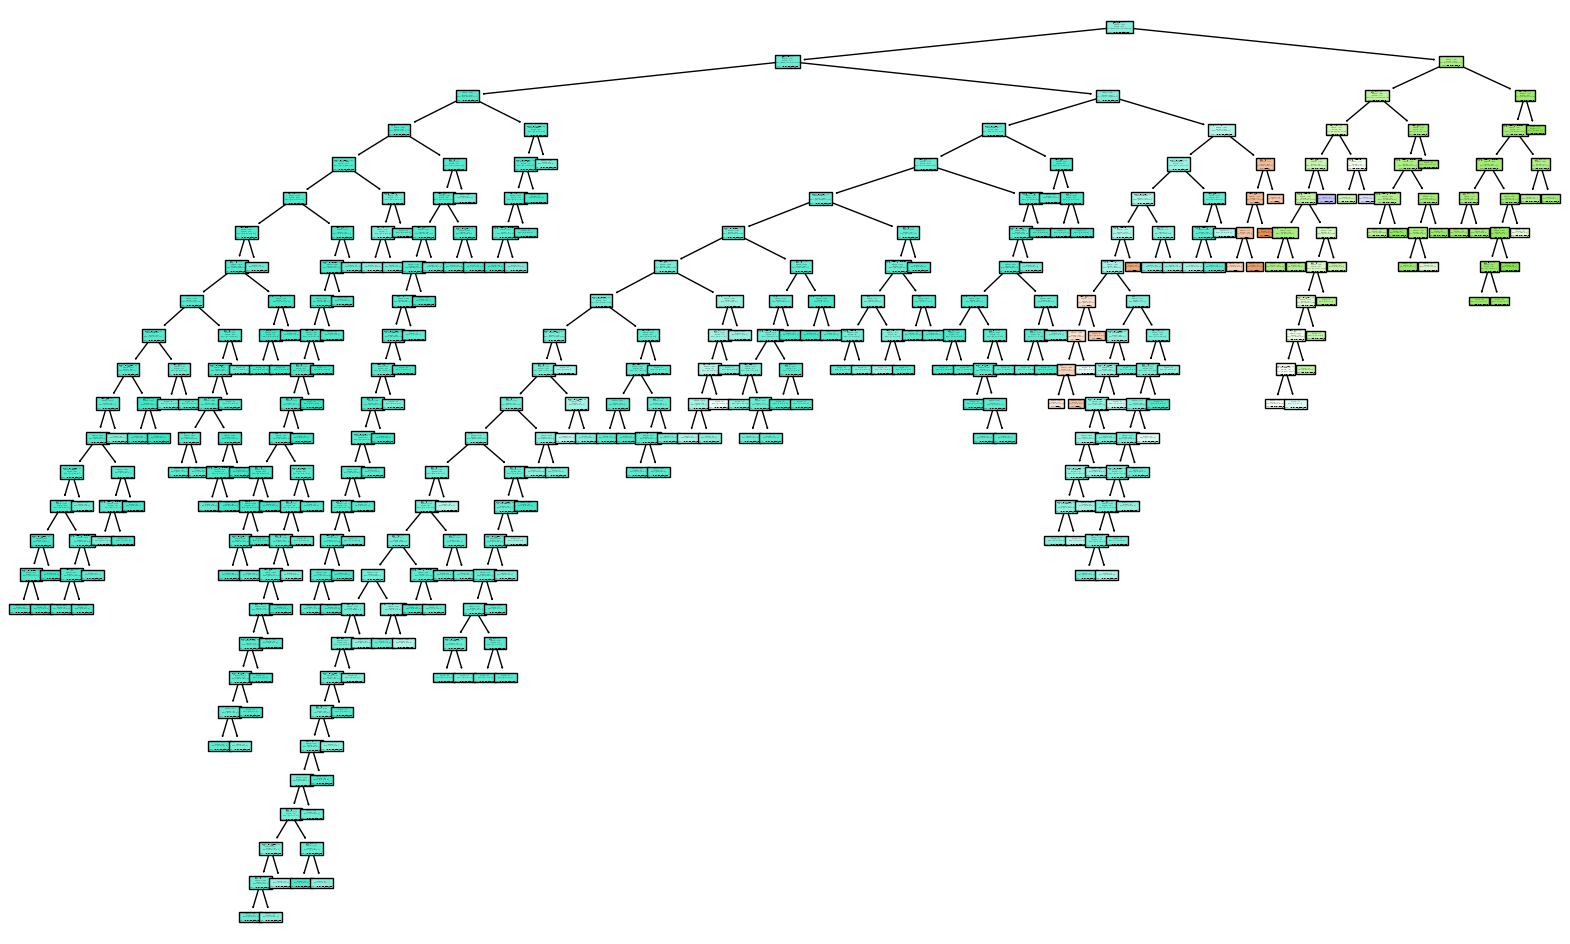

In [58]:

# 첫 번째 트리 시각화
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),  
    filled=True,
    ax=ax
)
plt.show()

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np


# 탐색할 하이퍼파라미터 설정
param_dist = {"n_estimators": np.arange(100, 200),
              "max_depth": np.arange(1, 31),
              "max_features": np.arange(1, 31),
              "min_samples_split": np.arange(10, 31),
              "min_samples_leaf": np.arange(10, 31),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"]}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=5)

# 랜덤 서치 수행
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_...
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199])})

In [17]:
best_params = random_search.best_params_
rf = RandomForestClassifier(**best_params, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features=15,
                       min_samples_leaf=22, min_samples_split=22,
                       n_estimators=137, random_state=42)

In [18]:
accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())

Accuracy:  0.7751798561151079
교차 검증 정확도:  [0.78057554 0.7803186  0.76849949 0.77589309 0.78411719]
평균 정확도:  0.7778807816176843


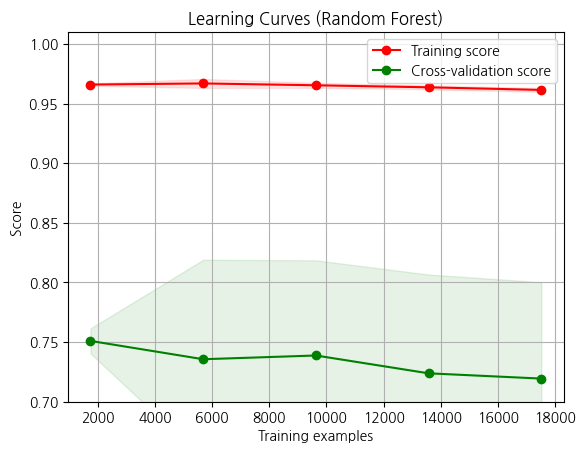

In [20]:
from sklearn.model_selection import learning_curve
import numpy as np
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 랜덤 포레스트 분류기를 사용한 학습 곡선
title = "Learning Curves (Random Forest)"
cv = 10
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

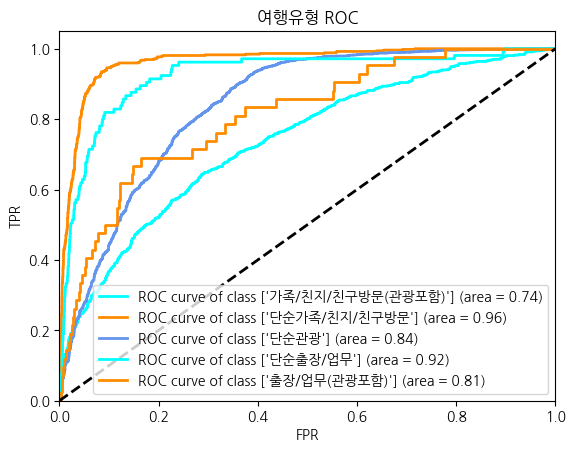

In [21]:
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# 예측 확률을 계산합니다.
y_score = rf.predict_proba(X_test)

# 각 클래스에 대해 ROC 커브를 계산하고 그립니다.
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    original_label = le.inverse_transform([i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(original_label, roc_auc))
    
# 랜덤 추측에 대한 ROC 커브를 그립니다.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('여행유형 ROC')
plt.legend(loc="lower right")
plt.show()

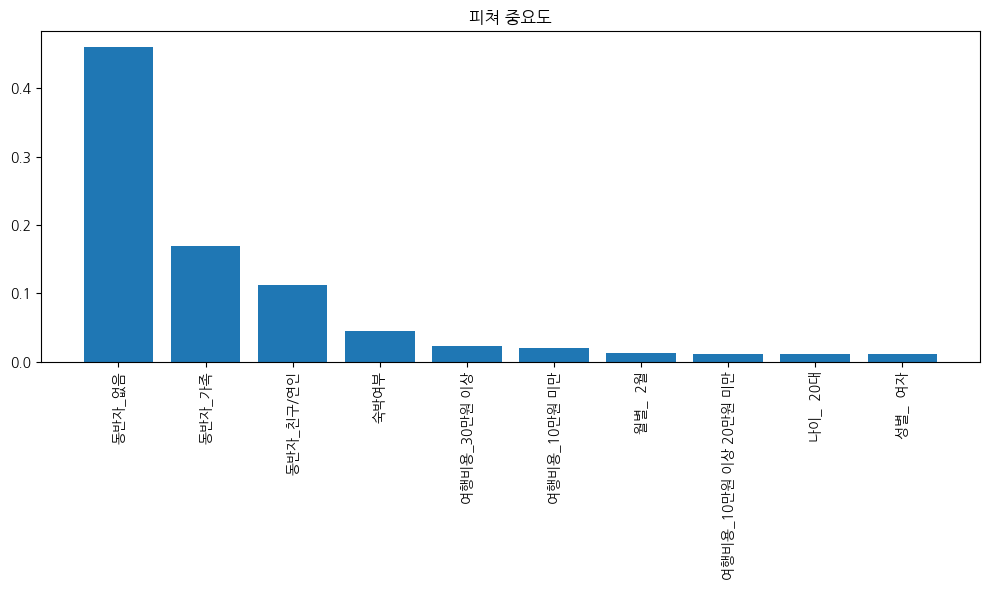

In [26]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.title('피쳐 중요도')
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), X.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig('top_10_feature_importance.png')

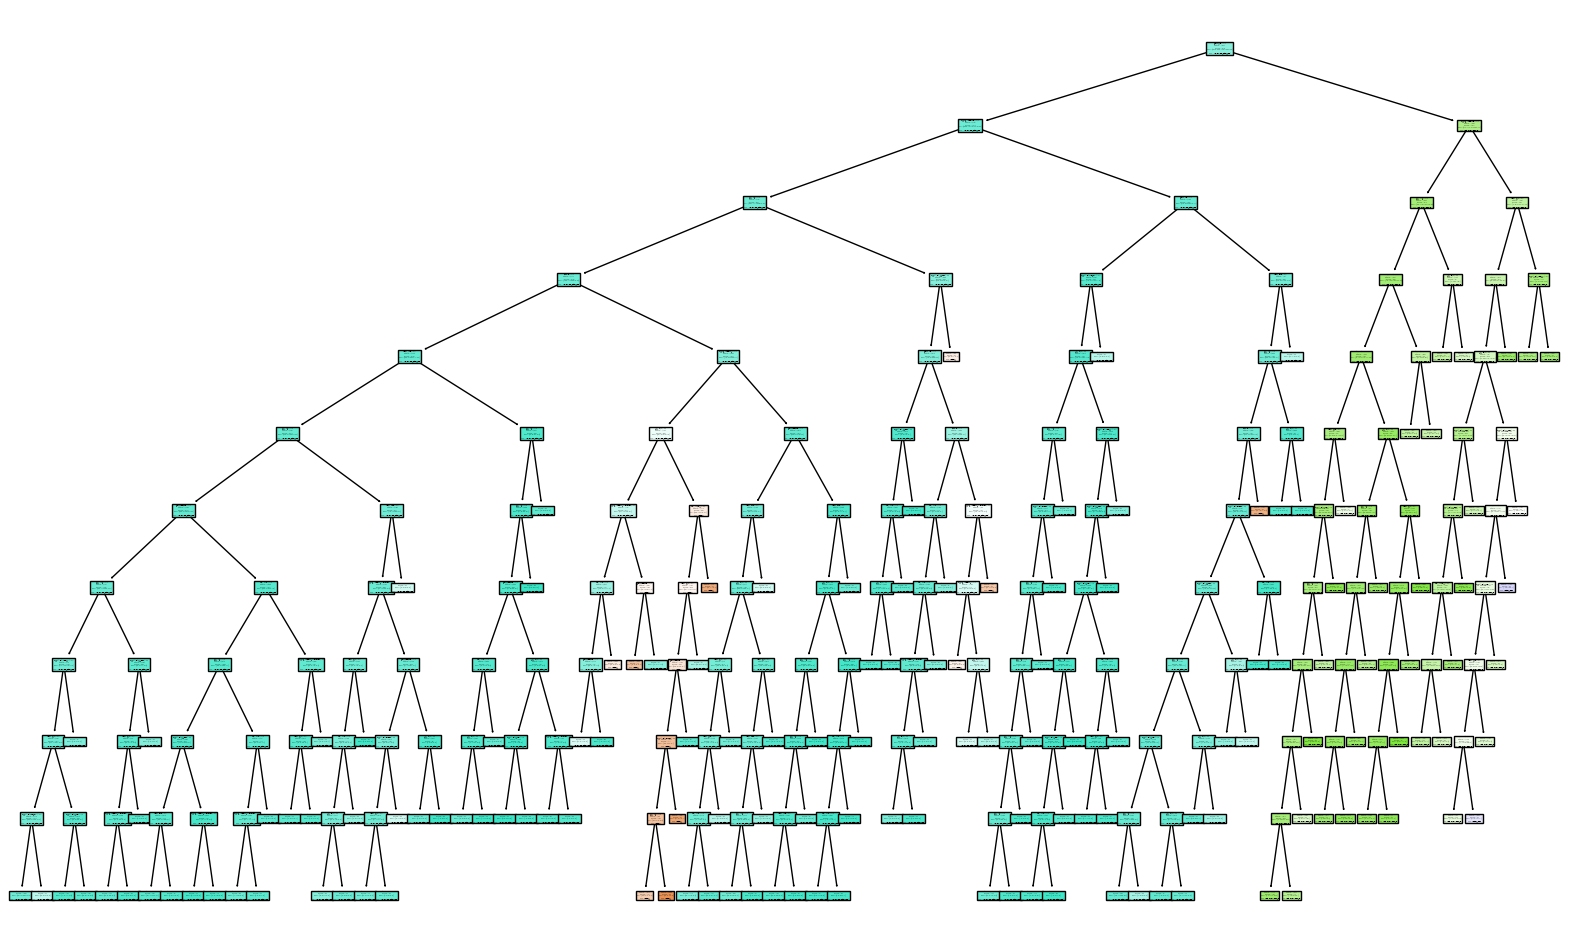

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),  
    filled=True,
    ax=ax
)
plt.show()

In [128]:
from sklearn.decomposition import PCA

# PCA로 차원 축소
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
y = train['여행유형']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 성능 평가
print("테스트 세트 정확도: {:.2f}".format(rf.score(X_test, y_test)))

테스트 세트 정확도: 0.71


In [60]:
rf = RandomForestClassifier()

# 탐색할 하이퍼파라미터 설정
param_dist = {"n_estimators": np.arange(100, 400),
              "max_depth": [3, None],
              "max_features": np.arange(1, 31),
              "min_samples_split": np.arange(2, 31),
              "min_samples_leaf": np.arange(1, 31),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=5)

# 랜덤 서치 수행
random_search.fit(X_2d, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24...
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399])})

In [61]:
best_params = random_search.best_params_
print(best_params)

{'n_estimators': 294, 'min_samples_split': 27, 'min_samples_leaf': 26, 'max_features': 17, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


In [129]:
param_dist ={'n_estimators': 294, 'min_samples_split': 27, 'min_samples_leaf': 26, 
             'max_features': 17, 'max_depth': None, 'criterion': 'entropy', 
             'bootstrap': True}

rf = RandomForestClassifier(**param_dist, random_state=42)
rf.fit(X_2d, y)

RandomForestClassifier(criterion='entropy', max_features=17,
                       min_samples_leaf=26, min_samples_split=27,
                       n_estimators=294, random_state=42)

In [130]:
accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X_2d, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())

Accuracy:  0.7602774922918808
교차 검증 정확도:  [0.76002055 0.75745118 0.75462487 0.75096376 0.75327679]
평균 정확도:  0.7552674327109521


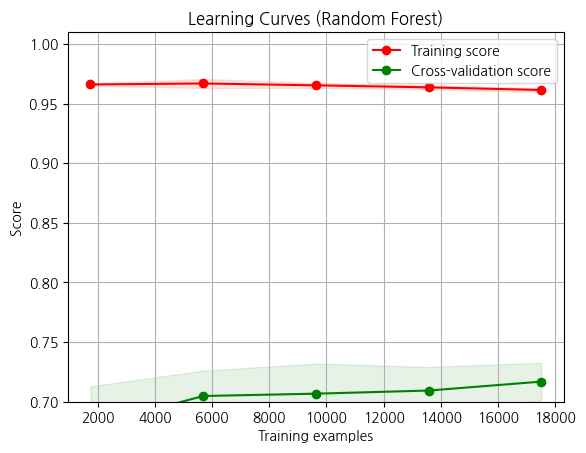

In [131]:
def plot_learning_curve(estimator, title, X_2d, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_2d, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 랜덤 포레스트 분류기를 사용한 학습 곡선
title = "Learning Curves (Random Forest)"
cv = 10
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X_2d, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

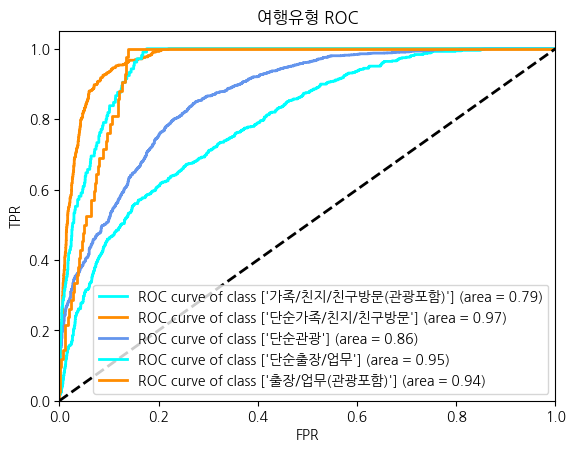

In [132]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# 예측 확률을 계산합니다.
y_score = rf.predict_proba(X_test)

# 각 클래스에 대해 ROC 커브를 계산하고 그립니다.
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    original_label = le.inverse_transform([i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(original_label, roc_auc))
    
# 랜덤 추측에 대한 ROC 커브를 그립니다.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('여행유형 ROC')
plt.legend(loc="lower right")
plt.show()

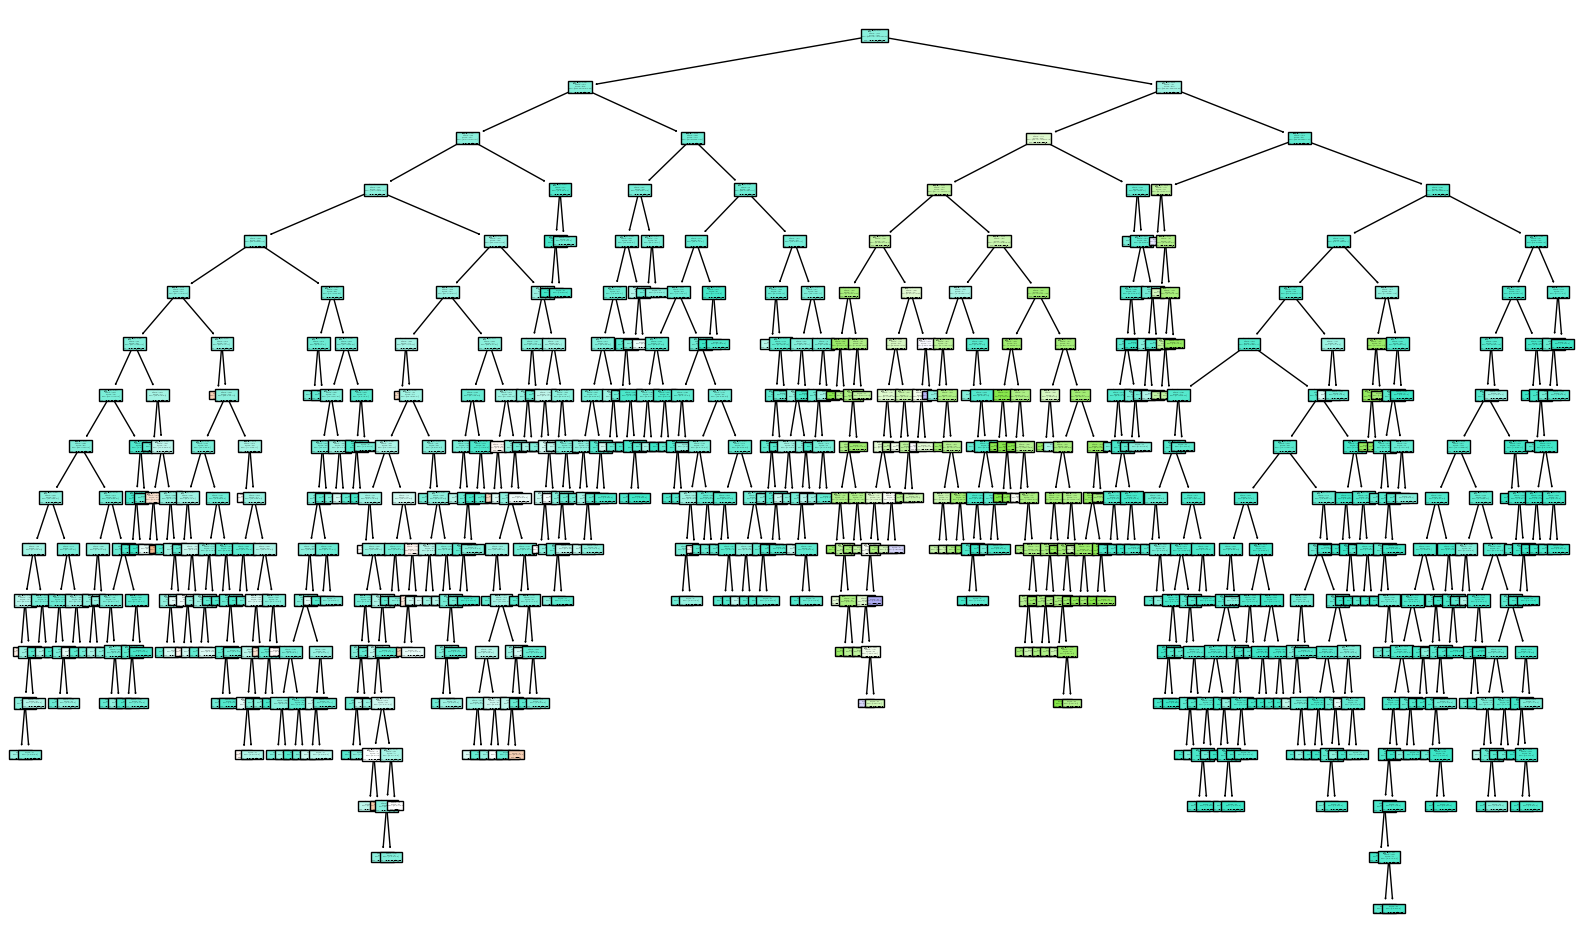

In [66]:
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),  
    filled=True,
    ax=ax
)
plt.show()

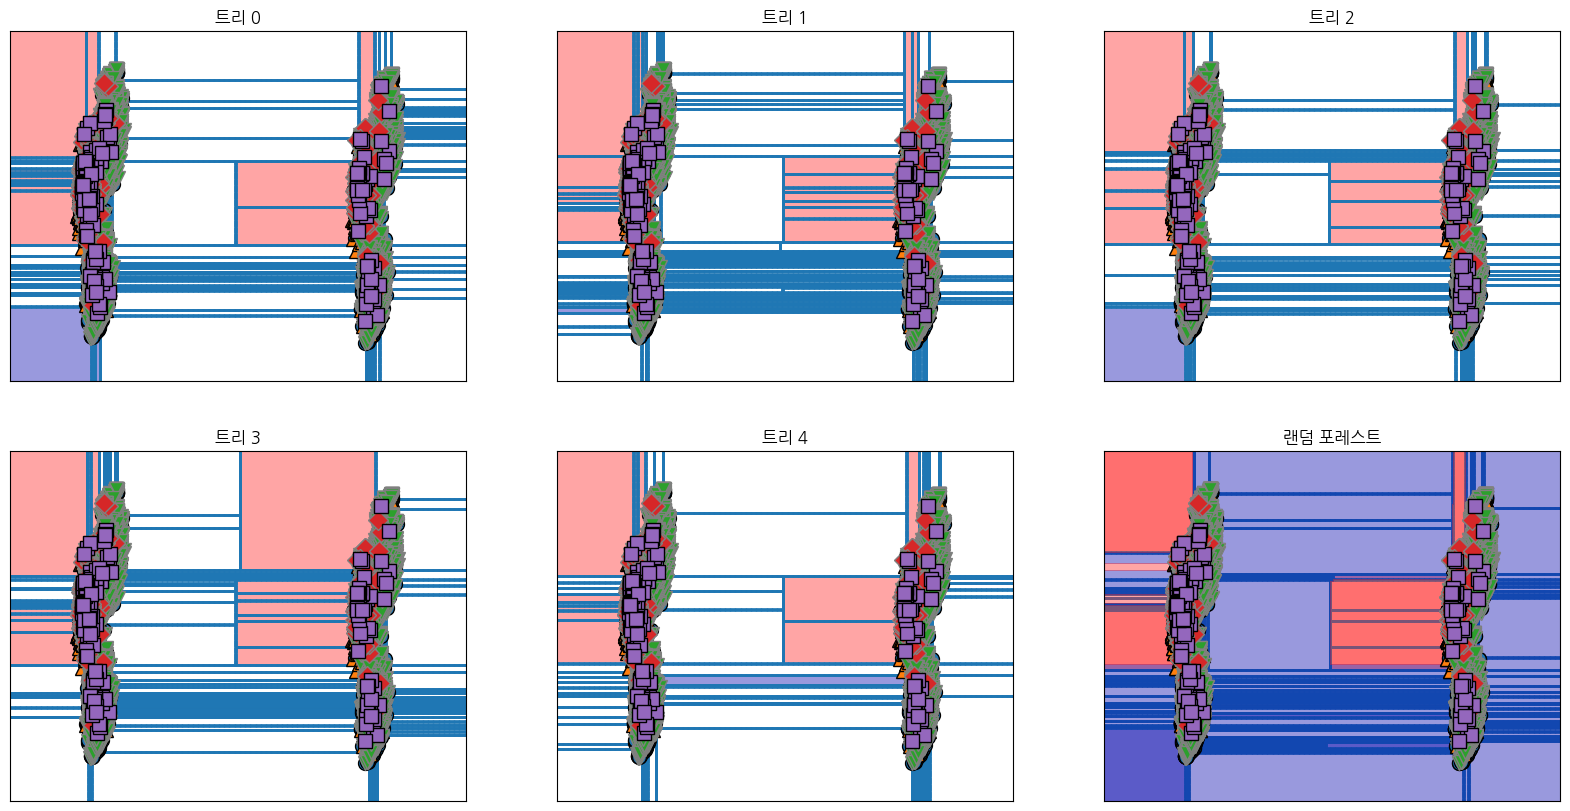

In [69]:
import mglearn


fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), rf.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(X_2d, y, tree, ax=ax)

mglearn.plots.plot_2d_separator(rf, X_2d, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("랜덤 포레스트")
mglearn.discrete_scatter(X_2d[:, 0], X_2d[:, 1], y)
plt.show()

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("가공데이터.csv")
train = data.copy()
train.head()


성별        나이   거주지          여행유형    월별    동반자 여행지(시/도) 여행지(시/군/구)  숙박여부  \
0    남자       40대    서울          단순관광    1월  친구/연인      강원도        춘천시     0   
1    여자    15~19세    서울  단순가족/친지/친구방문    2월  친구/연인      경기도        용인시     0   
2    여자       40대    서울  단순가족/친지/친구방문    2월     없음      경기도        용인시     1   
3    남자       40대    서울          단순관광    2월     가족      경기도        안산시     0   
4    여자       60대    서울          단순관광    2월     가족    인천광역시        강화군     0   

              여행비용  
0  10만원 이상 20만원 미만  
1          10만원 미만  
2  10만원 이상 20만원 미만  
3          10만원 미만  
4  10만원 이상 20만원 미만

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = train.drop('여행유형', axis=1)
y = train['여행유형']

most_frequent_class = y.value_counts().idxmax()

under_sampler = RandomUnderSampler(sampling_strategy={most_frequent_class: int(y[y==most_frequent_class].count()*0.8)}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X, y)

num_samples = y_under.value_counts().max()
sampling_strategy = {cls: num_samples for cls in y_under.unique() if cls != most_frequent_class}

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = over_sampler.fit_resample(X_under, y_under)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['여행유형'] = y_resampled

In [5]:
resampled_data['여행유형'].value_counts()

여행유형
가족/친지/친구방문(관광포함)    10364
단순가족/친지/친구방문        10364
단순관광                10364
단순출장/업무             10364
출장/업무(관광포함)         10364
Name: count, dtype: int64

In [ ]:
# resampled_data.to_csv("rf_data.csv", index=False)

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

X = pd.get_dummies(resampled_data.drop('여행유형', axis=1))  
y = resampled_data['여행유형']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier()
param_dist = {"n_estimators": np.arange(100, 500),
              "max_depth": [20, 24, 26, 28, None],
              "max_features": np.arange(1, 31),
              "min_samples_split": np.arange(2, 31),
              "min_samples_leaf": np.arange(1, 31),
              "bootstrap": [True,False],
              "criterion": ["gini", "entropy"]}


random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=5)

random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 24, 26, 28, None],
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 2...
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499])})

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = pd.get_dummies(resampled_data.drop('여행유형', axis=1))  
y = resampled_data['여행유형']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param = {'n_estimators': 490, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}


rf = RandomForestClassifier(**param, random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [8]:
from sklearn.model_selection import cross_val_score

accuracy = rf.score(X_test, y_test)
print('Accuracy: ', accuracy)

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("교차 검증 정확도: ", scores)
print("평균 정확도: ", scores.mean())

Accuracy:  0.9489579313006561
교차 검증 정확도:  [0.93979159 0.94953686 0.96246623 0.96150135 0.96179081]
평균 정확도:  0.9550173678116558


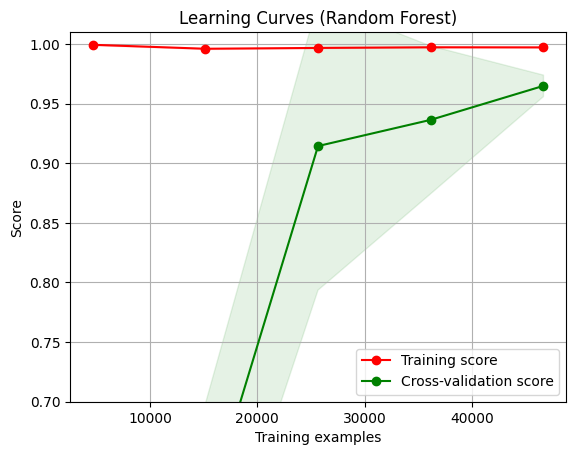

In [9]:
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forest)"
cv = 10
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [10]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, rf_pred, output_dict=True)
report_dict = classification_report(y_test, rf_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_df 

precision    recall  f1-score       support
가족/친지/친구방문(관광포함)   0.881478  0.899168  0.890235   2043.000000
단순가족/친지/친구방문       0.965565  0.990113  0.977685   2124.000000
단순관광               0.912210  0.858092  0.884324   2107.000000
단순출장/업무            0.990622  0.998507  0.994549   2010.000000
출장/업무(관광포함)        0.993314  1.000000  0.996646   2080.000000
accuracy           0.948958  0.948958  0.948958      0.948958
macro avg          0.948638  0.949176  0.948688  10364.000000
weighted avg       0.948571  0.948958  0.948542  10364.000000

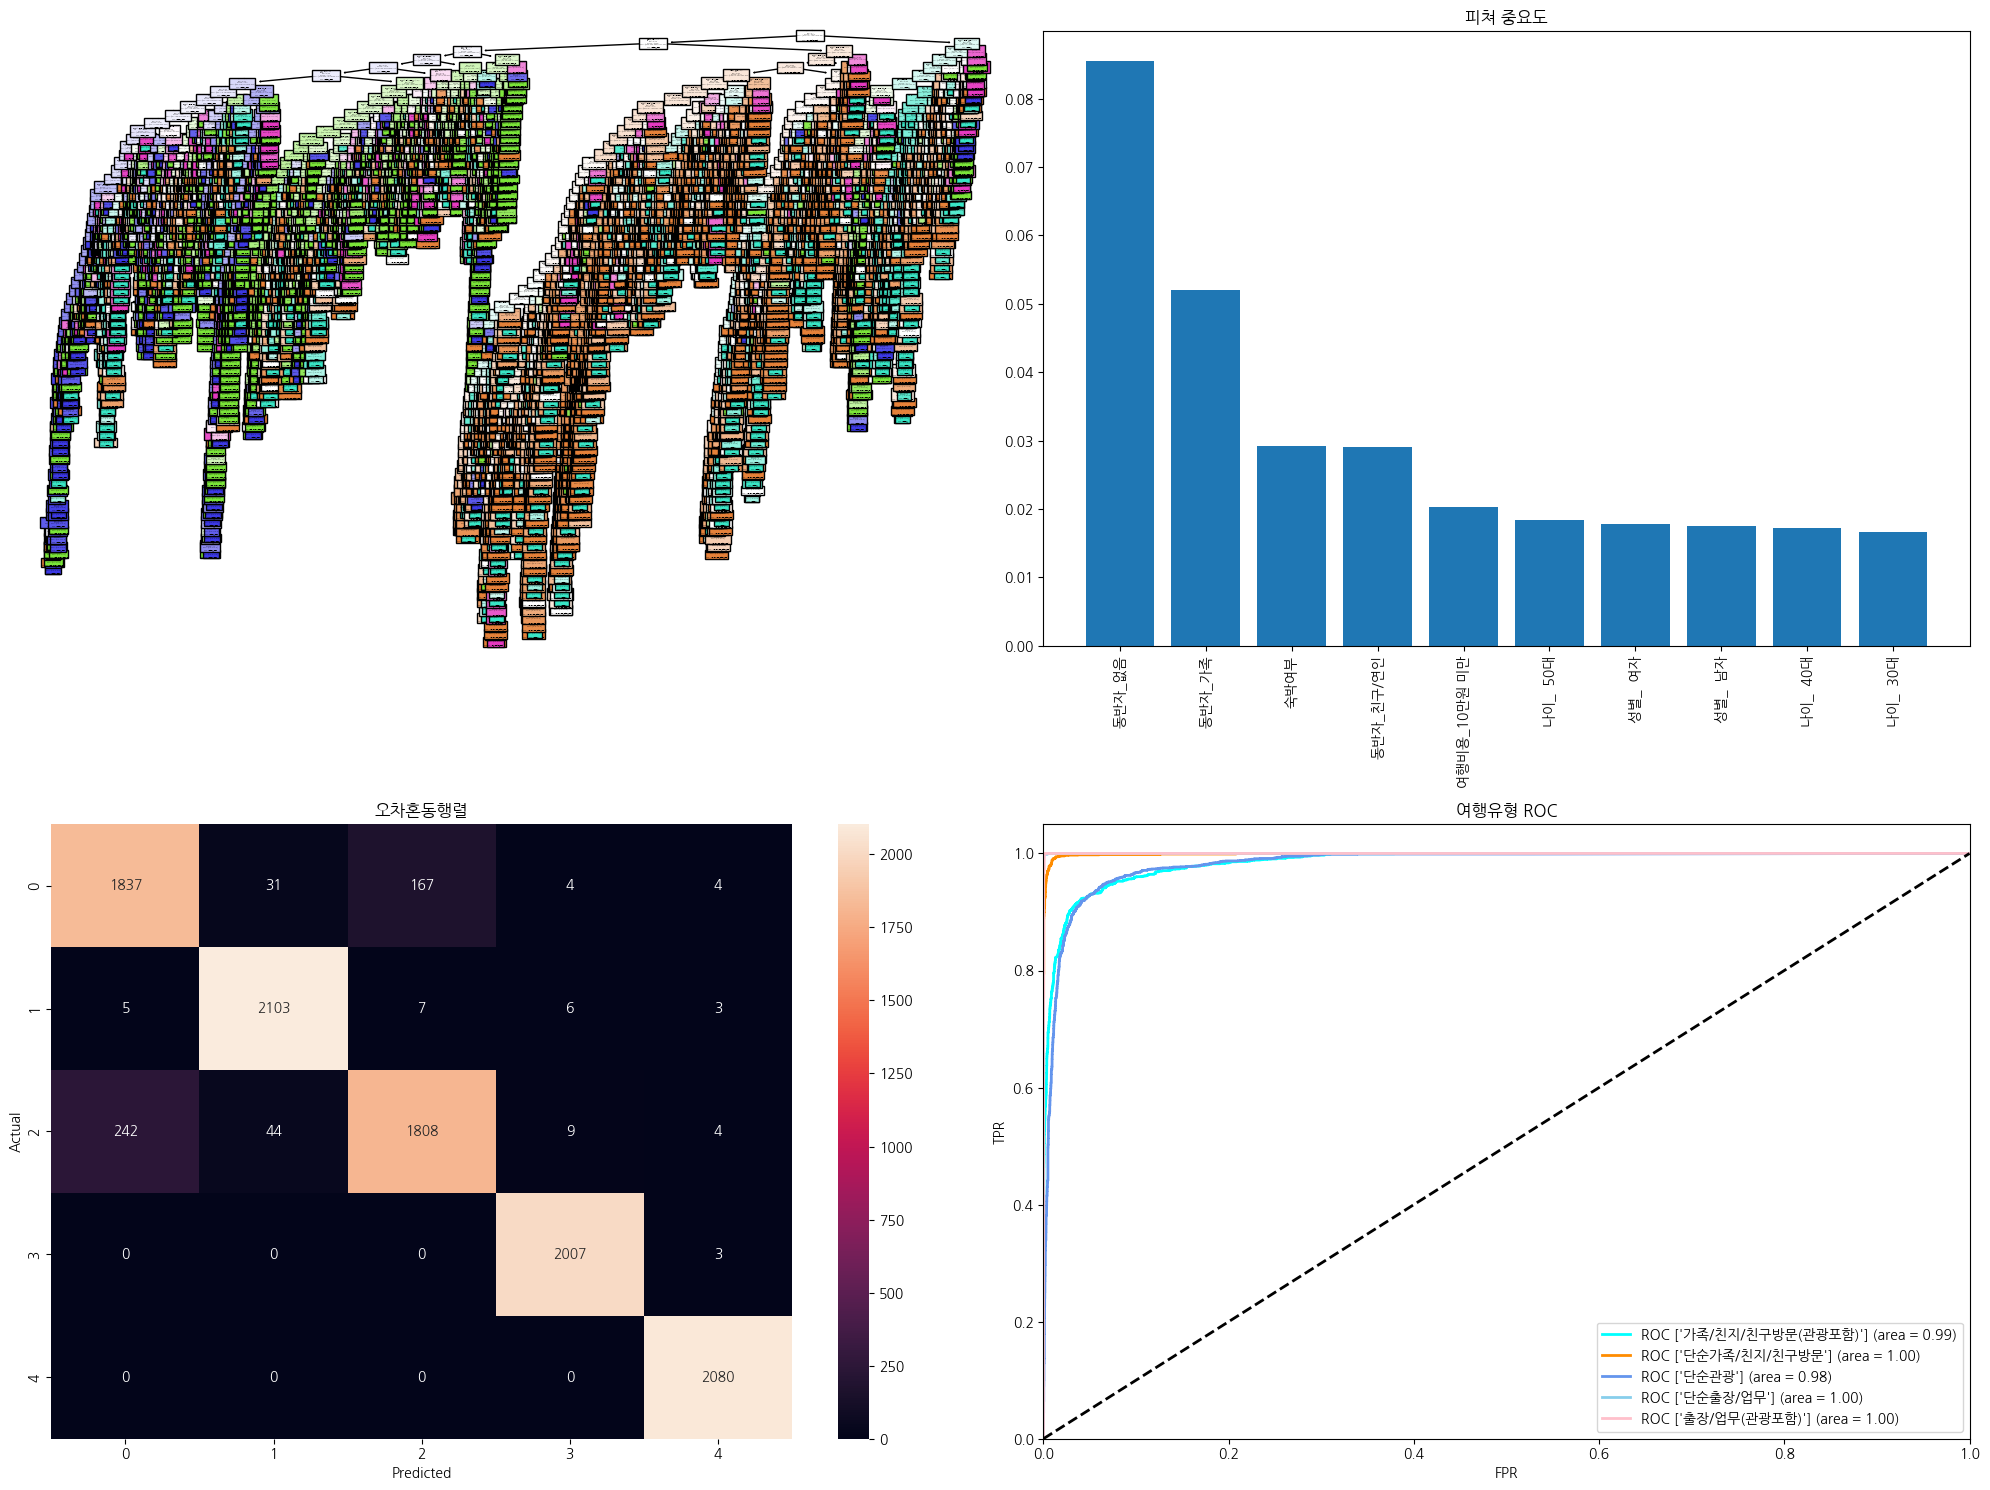

In [12]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.calibration import label_binarize
from sklearn.tree import plot_tree
from sklearn.metrics import auc, confusion_matrix, roc_curve
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  
font = fm.FontProperties(fname=font_path, size=10)
plt.rc('font', family='NanumGothic')  
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

y_score = rf.predict_proba(X_test)
fig, axs = plt.subplots(2, 2, figsize=(20, 15)) 


# 1. 트리 그래프
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True,
    ax=axs[0, 0]
)


# 2. 피쳐 중요도
axs[0, 1].set_title('피쳐 중요도')
axs[0, 1].bar(range(10), importances[indices], align='center')
axs[0, 1].set_xticks(range(10))
axs[0, 1].set_xticklabels(X.columns[indices], rotation=90)

# 3. Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt=".0f", ax=axs[1, 0])
axs[1, 0].set_title('오차혼동행렬')
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Actual')


# 4. ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'skyblue', 'pink'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    original_label = le.inverse_transform([i])
    axs[1, 1].plot(fpr, tpr, color=color, lw=2,
                   label='ROC {0} (area = {1:0.2f})'
                   ''.format(original_label, roc_auc))
    

axs[1, 1].plot([0, 1], [0, 1], 'k--', lw=2)
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel('FPR')
axs[1, 1].set_ylabel('TPR')
axs[1, 1].set_title('여행유형 ROC')
axs[1, 1].legend(loc="lower right")


plt.tight_layout()
plt.show()